# Source Code for implementing ACO for the MAPF problem

* Create algorithm for ACO (done)
* Create test promles (done / more or less)
* Create algorithm for time-expansion of the graph (working)
* Create Multi-Agent-ACO solver

Working Title: "Cooperative Co-Evolution of Intent: Soving the Multi-Agent Path Finding Problem with Ant Colony Optimisation"

Abstract:
* ACO is used to solve path finding problems in graphs
* The pheromone-matrix represents the intent of an agent
* A solution to the MAPF can be viewed as a state of consent of intentions
* Two problems need to be solved: 
    * Time Extension of ACO
    * Ants that consider other agents intent
* Experiments: in progress
* Works?

In [1]:
# install the required packages
%pip install matplotlib pandas seaborn numpy networkx ipywidgets netgraph ipympl smac

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=np.inf, precision=3)
import networkx as nx
import ipywidgets as widgets

In [3]:
class NavigationProblem:
    def __init__(self, start=0, goal=0, adjacency=None, pheromones=None):
        self.adjacency = adjacency
        self.pheromones = pheromones
        self.start = start
        self.goal = goal
    
    def set_pheromone_ones(self):
        self.pheromones = np.ones_like(self.adjacency)
        for i, j in np.ndindex(self.adjacency.shape):
            if self.adjacency[i,j] == 0 and i != j:
                self.pheromones[i,j] = 0
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels) 

        

In [4]:
G = nx.watts_strogatz_graph(145,4, 0.01, seed=42)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
problem_hard_1 = NavigationProblem(start=0, goal=75, adjacency=nx.adj_matrix(G).todense())
problem_hard_1.set_pheromone_ones()

G = nx.watts_strogatz_graph(42,4,0.05, seed=23)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
problem_middle_1 = NavigationProblem(start=0, goal=27, adjacency=nx.adj_matrix(G).todense())
problem_middle_1.set_pheromone_ones()

G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 5, weight=1)
G.add_edge(1, 4, weight=3)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=1)
G.add_edge(5, 7, weight=1)
G.add_edge(6, 7, weight=3)
G.add_edge(7, 8, weight=1)
#G.add_edge(5, 9)
problem_easy_1 = NavigationProblem(start = 0, goal = 8, adjacency = nx.adj_matrix(G).todense())
problem_easy_1.set_pheromone_ones()


G = nx.Graph()
G.add_edge(0, 1, weight=1.0)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 4, weight=1.0)
problem_easy_2 = NavigationProblem(start = 0, goal = 3, adjacency = nx.adj_matrix(G).todense())
problem_easy_2.set_pheromone_ones()

G = nx.Graph()
G.add_edge(0, 1, weight=1.0)
G.add_edge(0, 2, weight=1.0)
G.add_edge(1, 3, weight=1.0)
G.add_edge(2, 3, weight=1.0)
problem_easy_3 = NavigationProblem(start = 0, goal = 3, adjacency = nx.adj_matrix(G).todense())
problem_easy_3.set_pheromone_ones()

G = nx.Graph()
G.add_edge(1, 2, weight=1.0)
G.add_edge(2, 3, weight=1.0)
G.add_edge(2, 4, weight=1.0)
G.add_edge(4, 5, weight=1.0)
G.add_edge(5, 7, weight=1.0)
G.add_edge(7, 6, weight=1.0)
G.add_edge(4, 6, weight=1.0)
G.add_edge(6, 8, weight=1.0)
problem_easy_4 = NavigationProblem(start = 0, goal = 7, adjacency = nx.adj_matrix(G).todense())
problem_easy_4.set_pheromone_ones()

In [5]:
def draw_pheromone_matrix(adjacency=None, pheromones=None, label=True, time=-1, width=15, height=15, thickness=3, show=True, prune=0, node_label=True, start=0, goal=0, size=1.0, cutoff=1e-10, pos=None):
    plt.figure(figsize=(width,height))
    matrix = None
    if pheromones is not None:
        matrix = pheromones.copy()
    else:
        matrix = adjacency.copy()
    
    for i, j in np.ndindex(matrix.shape):
        if matrix[i, j] < cutoff:
            matrix[i, j] = 0
    G = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph())
    if pos is None:
        Ga = nx.from_numpy_matrix(adjacency)
        pos = nx.kamada_kawai_layout(Ga)
    weight = nx.get_edge_attributes(G,'weight')
    node_colors = ["lightblue" for _ in range(matrix.shape[0])]
    node_colors[start] = "red"
    node_colors[goal] = "green"
    labels = { k : f"{v:.2f}" for k, v in weight.items()}
    width = [(max(prune, w['weight']) - prune) * thickness /np.max(matrix) for u, v, w in G.edges(data=True)]
    nx.draw_networkx_nodes(G,pos=pos, node_color=node_colors, node_size=[size * 300 * (1 + v) for v in np.diag(matrix)])
    nx.draw_networkx_edges(G,pos, width=width, alpha=0.3, connectionstyle='arc3,rad=0.2', arrowstyle="-|>", arraowsize=thickness*3)
    if node_label:
        node_labels=None
        if label:
            node_labels = {k : f"{np.diag(matrix)[k]:.2f}" for k in range(matrix.shape[0])}
        nx.draw_networkx_labels(G, pos=pos, labels=node_labels)

    if label:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.3)
        
    if show:
        plt.show()
        

In [6]:
def fitness_proportional_selection(probs, random=np.random.rand()):
    s = sum(probs.values())
    pick = random * s
    current = 0
    for key in sorted(probs):
        current += probs[key]
        if current >= pick:
            return key
    print("selection could not pick an item - should not happen!")
    return probs[-1]
        

class Ant:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None, seed = None):
        self.seed = seed
        self.random = np.random.RandomState(seed=seed)
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        self.stuck = False
        self.selection = self.ant_system_selection
        self.forward = True
        
        self.setup()
        
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, value = 0.5):
        factor = 1 * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
    def delayed_update(self):
        amount = 1/self.distance
        for i in range(len(self.path)-1):
            self.pheromones[self.path[i], self.path[i+1]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
    
    def random_selection(self, new):
        return self.random.choice(new)
    
    def value(self, i, j, alpha=0.5, beta=0.5, **kwargs):
        if not self.forward:
            i, j = j, i
        d = self.adjacency[i,j]
        return np.max([np.finfo(float).eps,self.pheromones[i,j]])**alpha * (1/d)**beta
    
    def ant_system_selection(self,state, new, **kwargs):
        probs = {k : self.value(state, k, **kwargs) for k in new }
        return fitness_proportional_selection(probs, self.random.rand())
        
    
    def get_time(self):
        return len(self.path)-1
    
    def roulette_wheel_selection(self, state ,new, probs = None):
        if probs is None:
            probs = {k : self.pheromones[state, k] for k in new }
        return fitness_proportional_selection(probs, self.random.rand())

    def setup(self, start=None, goal=None, invert_direction=False, **kwargs):
        if start:
            self.start = start
        if goal:
            self.goal = goal
            
        if invert_direction:
            self.start, self.goal = self.goal, self.start
            self.forward = not self.forward
        self.stuck = False
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
            
    def step(self, selection=None, allow_revisit=False, allow_wait=False, **kwargs):
        if selection:
            self.selection = selection
        if not self.selection:
            self.selection = self.ant_system_selection
        
        # compute next possible states $new
        new = [node for node in range(len(self.adjacency))]
        if not (allow_revisit and self.forward):
            new = [node for node in new if not (node in self.path)]
        
        new = [node for node in new if not (self.adjacency[self.state, node] == 0)]
        
        if allow_wait and self.forward:
            new.append(self.state)
        
        # in case no more states are possible: return
        if not new:
            self.stuck=True
            return
        
        # pick a new state from the list
        self.state = self.selection(self.state, new, forward=self.forward, **kwargs)
        self.path.append(self.state)
        d = self.adjacency[self.path[-2], self.path[-1]]
        #print(f"current distance: {d}")
        self.distance += d
        

class ACO:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None, seed = None, num_paths=100, **kwargs):
        self._pos = None # for saving the graph layout (plotting)
        self.seed = seed
        self._num_paths = num_paths
        self.random = np.random.RandomState(seed=seed)
        self.start = start
        self.goal = goal
        self.adjacency = adjacency
        self.paths = []
        if pheromones is not None:
            self.pheromones = pheromones
        else:
            self.pheromones = np.ones_like(self.adjacency)
        self.best_distance = np.inf
        self.best_path = [start]
        self.kwargs = kwargs
        assert self.pheromones.shape == self.adjacency.shape
        for i in range(self.adjacency.shape[0]):
            for j in range(self.adjacency.shape[1]):
                if self.adjacency[i, j] == 0:
                    self.pheromones[i, j] = 0
        
        self.pheromone_timeline = [self.pheromones.copy()]
        self.distance_timeline = [self.best_distance]
        self.create_ants()

        
    def create_ants(self, num_ants = 10):
        self.ants = [Ant(start=self.start, goal=self.goal, pheromones=self.pheromones, adjacency=self.adjacency, seed=self.random.randint(2**32)) for _ in range(num_ants)]
   
    def online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            amount = 1 / self.adjacency[ant.path[-2],ant.path[-1]]
            if ant.forward:
                self.pheromones[ant.path[-2], ant.path[-1]] += amount
            else:
                self.pheromones[ant.path[-1], ant.path[-2]] += amount
                
            
    def delayed_online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            if ant.state == ant.goal:
                amount = 1 / ant.distance
                path = ant.path
                if not ant.forward:
                    path.reverse()
                for i in range(len(path) - 1):
                    self.pheromones[path[i], path[i+1]] += amount
    
    def penalize_stuck(self, stuck_penalty=0.1, **kwargs):
        for ant in self.ants:
            if ant.stuck:
                self.pheromones[ant.path[-2], ant.path[-1]] += -stuck_penalty
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, gamma = 1, normalize_eps=0, **kwargs):
        self.pheromones -= normalize_eps
        np.clip(np.inf, 0, self.pheromones, out=self.pheromones)
        factor = gamma * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
        
    def step(self, **kwargs):
        for ant in self.ants:
            ant.step(**kwargs)

    def daemon_actions(self, reverse_ants=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.stuck:
                ant.setup()
            if ant.state == ant.goal:
                if not ant.forward: 
                    ant.path.reverse()
                self.paths.append(ant.path)
                if len(self.paths) > self._num_paths:
                    self.paths = self.paths[-self._num_paths:]
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                ant.setup(invert_direction=reverse_ants)
        self.distance_timeline.append(self.best_distance)
    
    
    def update_pheromones(self, delayed_update=True, evaporation_method="normalize", log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        if delayed_update:
            self.delayed_online_pheromone_update(**kwargs)
        else:
            self.online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / len(self.ants)
            for i in range(len(self.best_path) - 1):
                self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
                
        
        # evaporation
        if evaporation_method == "normalize":
            self.normalize(**kwargs)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
            
    def run(self, generations=1000, **kwargs):
        self.kwargs.update(kwargs)
        for generation in range(generations):
            self.step(**self.kwargs)
            self.update_pheromones(**self.kwargs)
            self.daemon_actions(**self.kwargs)
    
    def widget_pheromones(self):
        w = widgets.interact(self.draw_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 generation=widgets.IntSlider(min=-1,max=len(self.pheromone_timeline)-1,step=1,value=-1),
                 thickness=widgets.FloatLogSlider(value=3),
                 size=widgets.fixed(1)
                );
        display(w)
    
    def get_graph_layout(self):
        if self._pos is None:
            Ga = nx.from_numpy_matrix(self.adjacency)
            self._pos = nx.kamada_kawai_layout(Ga)
        return self._pos
            
    def draw_pheromones(self, generation=-1, **kwargs):
        print(f"Best Distance Found: {self.distance_timeline[generation]}\n{self.best_path}")
        draw_pheromone_matrix(pheromones=self.pheromone_timeline[generation], adjacency=self.adjacency, start=self.start, goal=self.goal, pos=self.get_graph_layout(), **kwargs)
        
    
    def draw_adjacency(self, **kwargs):
        draw_pheromone_matrix(adjacency=self.adjacency, start=self.start, goal=self.goal, **kwargs)
        
        

Best Distance Found: 11.048001897492716
[0, 144, 142, 141, 120, 119, 121, 123, 82, 81, 79, 77, 75]


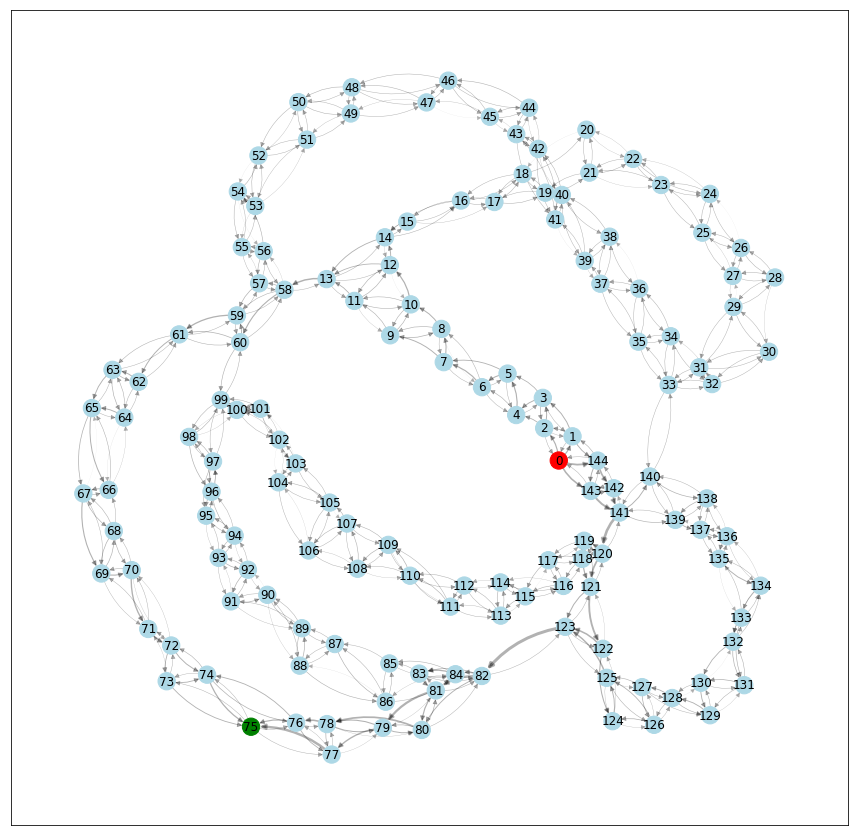

In [7]:
aco = ACO(start=problem_hard_1.start, goal=problem_hard_1.goal, pheromones=problem_hard_1.pheromones.copy(), adjacency=problem_hard_1.adjacency.copy(), seed=43)
aco.run(generations=600, elitst_update=True, alpha=0.8, beta=0.2, reverse_ants=True, penalize_stuck=True)
aco.draw_pheromones(label=False)

In [8]:
#aco.widget_pheromones()

## Time extension and foreign Agent ... of ACO

### Time Extension
Time extension works by unrolling the pheromone matrix throughout time. In each time step t the pheromone matrix $\mathcal{P}(t)$ is used for the pheromone update.
The values $\tau_{ij, t}$ are updated after an ant reaches the goal. In the time extended form, circular paths (in space) and waiting is also allowed.

There are two decision rules governing the behaviour of the ants. On its way from start to goal the ant follows the (time-)global pheromone matrix $P$, the time extended pheromone matrix $\mathcal{P}(t)$ and the foreign time extended pheromones at the current timestep $\mathcal{P}_{f}(t)$.
As paths can be simliar through time the actual matrix used instead of $\mathcal{P}(t)$ is $\sum_{i=t-k}^{t+k} \mathcal{P}(i)$ with $k=3$.

#### Decision Rule

\begin{equation}
v = \color{blue}{\big(\frac{1}{p_{c} + \varepsilon_f}\big)^{\alpha_f}}\cdot \Big(\sum_{i=t-k}^{t+k} \mathcal{P}(i)\Big)_{ij}^{\alpha} \cdot \tau_{ij}^{\beta} + \varepsilon
\end{equation}

#### Update Rule
Each node in the path will get this amount of pheromones:
\begin{equation}
v = \big( \frac{c_t |\mathcal{T}|}{t_{goal}} + \frac{c_d}{\sum{d_e}} + \color{blue}{\frac{c_f}{\sum{\mathcal{P}_f(t)_{ij}}}} \big)
\end{equation}


In [9]:
#Implementation of TimeExtendedACO
class TimeExtendedACO(ACO):
    def __init__(self, timeframe=100, prerun_generations=1000, problem=None, seed=None, **kwargs):
        ACO.__init__(self, adjacency=problem.adjacency.copy(), pheromones=problem.pheromones.copy(), start=problem.start, goal=problem.goal, seed=seed, **kwargs)
        self.node_count = np.zeros((self.adjacency.shape[0], timeframe), dtype=int)
        self.node_sucess = np.zeros_like(self.node_count, dtype=int)
        self.df_convergence = pd.DataFrame()
        self.df_fitness = pd.DataFrame()
        #print(f"prerun for {prerun_generations} generations")
        self.run(generations=prerun_generations, **kwargs)
        self.extended_pheromones = np.ones((timeframe, self.pheromones.shape[0], self.pheromones.shape[1]))
        self.timeframe = timeframe
        self.best_path = []
        self.best_distance = np.inf
        self.iteration = 0
        # create new ants outside of the current graph
        self.create_ants()
        self.arrived = 0
        self.timeout = 0
        for ant in self.ants:
            ant.forward = True
            ant.selection = self.tAco_selection
            ant.penalty = np.zeros_like(self.pheromones)
        #for t in range(timeframe):
            #self.extended_pheromones[t] = self.pheromones
    
    def edge_collision_pheromones(self, i, j, foreign_pheromones=None):
        return foreign_pheromones[j, i] + foreign_pheromones[i, j]
    
    def node_collision_pheromones(self, j, foreign_pheromones=None):
        return np.sum(foreign_pheromones[:,j])
    
    def compute_p_foreign(self, i, j, foreign_pheromones=None, edge_collision_factor=3.0, forward=True):
        #ant has to go forward and foreign pheromones need to be present
        if not forward or foreign_pheromones is None:
            return 1.0
        
        p_foreign = self.node_collision_pheromones(j, foreign_pheromones=foreign_pheromones)
        #backward edge- no edge collisions
        p_foreign += edge_collision_factor * self.edge_collision_pheromones(i, j, foreign_pheromones=foreign_pheromones)
        return p_foreign
        
    
    def tAco_selection_value(self, i, j, edge_collision_factor=3, extended_pheromones=None, foreign_pheromones=None, alpha=0.5, eps=0.0001, beta=0.5, forward=True, alpha_foreign=1, eps_foreign=None, **kwargs):
        """computes the fitness value of a particular edge
        parameters:
        i -- from
        j -- to
        
        extended_pheromones -- time extended pheromone matrix
        alpha -- weight of the pheromone matrix
        eps -- fixed value added to all the options (high eps -> random walk)
        beta -- weight of the extended pheromone matrix
        forward -- if False, i and j are swapped
        """
        if not forward:
            #print("test")
            i, j = j, i
            
        if eps_foreign is None:
            eps_foreign = eps
            
        p = np.max([np.finfo(float).eps, self.pheromones[i, j]])
        p_ext = np.max([np.finfo(float).eps, extended_pheromones[i, j]])
        p_foreign = self.compute_p_foreign(i, j, foreign_pheromones=foreign_pheromones, edge_collision_factor=edge_collision_factor, forward=forward)
        #print(f"tAcoSelection_value- {i}, {j}: p: {p}, p_ext: {p_ext}, p_foreign:{p_foreign},  {p**alpha * p_ext**beta * (1 / (eps + p_foreign) ** alpha_foreign) + eps}")
        return  p**alpha * p_ext**beta * (1 / (eps_foreign + p_foreign**alpha_foreign)) + eps
    
    def extended_pheromones_sum(self):
        """normalized sum (over all time steps) of the time extended pheromone values"""
        return self.normalize_(np.sum(self.extended_pheromones, axis=0))
    
    def extended_pheromone_convolution(self, t, length=3, function=lambda x: 2 / abs(x + 1), argument=None):
        if argument is None:
            argument = self.extended_pheromones
        matrix = np.zeros_like(argument[t])
        for x in range(max(0, t-length), t+length):
            matrix += argument[x] * function(x)
        return self.normalize_(matrix)
    
    def tAco_selection(self, state, new, time=0, forward=True, foreign_pheromones=None, **kwargs):
        """select the next action based on time extended pheromones
        forward: select based on current time-step pheromone matrix
        backward: select based on sum of time extended pheromones
        """
        #print(f"tAcoSelection- state: {state}, new: {new}, time: {time}")
        probs = {}
        if forward:
            if foreign_pheromones is None:
                probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromone_convolution(time), **kwargs) for k in new }
            else:
                #print("there are foreign pheromones in tAco_selection")
                probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromone_convolution(time), foreign_pheromones=foreign_pheromones[time], **kwargs) for k in new }
        else:
            probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromones_sum(), forward=forward, **kwargs) for k in new }
        
        return fitness_proportional_selection(probs, random=self.random.rand())
        #selected = fitness_proportional_selection(probs, random=self.random.rand())
        #print(f"{selected} -- {probs}")
        #return selected
    
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize_(self, pheromones, gamma = 1, normalize_eps=0.0, **kwargs):
        x = np.clip(np.inf, 0, pheromones - normalize_eps)
        factor = gamma * x.shape[0] / np.sum(x)
        return x * factor
    
    def extended_step(self, **kwargs):
        for ant in self.ants:
            assert (ant.start == self.start) or not ant.forward
            if ant.forward:
                ant.step(selection=self.tAco_selection, allow_revisit=True, allow_wait=True, **kwargs)
            else:
                ant.step(selection=self.tAco_selection, allow_revisit=False, allow_wait=False, **kwargs)
            
    def run_extended(self, generations=1000, foreign_pheromones=None, show_progress=False,**kwargs):
        if show_progress:
            progress_bar = widgets.IntProgress(min=0, max=generations, description=f"computing {generations} generations")
            display(progress_bar)
        self.kwargs.update(kwargs)
        data = [self.df_convergence]
        for generation in range(generations):
            if show_progress:
                progress_bar.value = generation
            self.iteration += 1
            #if self.iteration % 1000 == 0:
                #print(f"iteration {self.iteration} --  arrived: {self.arrived}, timeout: {self.timeout}, ratio: {self.arrived / (self.arrived + self.timeout)}")
            self.extended_step(foreign_pheromones=foreign_pheromones, **self.kwargs)
            self.extended_update_pheromones(foreign_pheromones=foreign_pheromones, **self.kwargs)
            self.extended_daemon_actions(foreign_pheromones=foreign_pheromones, **self.kwargs)
            data.append(pd.DataFrame({"iteration":self.iteration, "arrived": self.arrived, "timout":self.timeout, "shortest":self.best_distance}, index=[self.iteration]))
        self.df_convergence = pd.concat(data)
            
    def extended_daemon_actions(self, reverse_ants=True, penalty_factor=0.01, depenalize_long_running=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.get_time() >= self.timeframe:
                #print(f"ant did not arrive {ant.path}")
                if depenalize_long_running:
                    self.depenalize_path(ant, penalty_factor)
                ant.setup()
                self.timeout += 1
                
            if ant.stuck:
                if ant.forward:
                    print("forward, should not be stuck")
                ant.setup()
            if ant.state == ant.goal:
                if ant.forward:
                    self.arrived += 1
                    self.paths.append(ant.path)
                    if len(self.paths) > self._num_paths:
                        self.paths = self.paths[-self._num_paths:]
                    for t in range(len(ant.path)):
                        self.node_count[ant.path[t],t] += 1
                    #print(f"ant arrived afer {ant.get_time()} steps: {ant.path} ")
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                ant.setup(invert_direction=reverse_ants)
        self.distance_timeline.append(self.best_distance)
    
    def been_there_done_that_penalty(self, path):
        """add fixed amount of penalty for every edge and every node visited"""
        penalty = np.zeros_like(self.pheromones)
        for n1, n2 in zip(path[1:], path[:-1]):
            penalty[n1, n2] = -1
            penalty[n2, n1] = -1
            #penalty[n1, n1] = -1
        return penalty
            
    
    def extended_online_pheromone_update(self, penalty_factor = 0.01, **kwargs):
        """lower the pheromones in future nodes, where the ant has alreadd visited in the past"""
        for ant in self.ants:
            if ant.forward:
                for t in range(ant.get_time(), self.timeframe):
                    self.extended_pheromones[t] = self.extended_pheromones[t] + penalty_factor * self.been_there_done_that_penalty(ant.path)
    
    def depenalize_path(self, ant, penalty_factor, **kwargs):
        """reverse the penalty of an ant"""
        for t in range(0,ant.get_time()):
            for t2 in range(t, self.timeframe):
                penalty = penalty_factor * self.been_there_done_that_penalty(ant.path[:t])
                self.extended_pheromones[t2] -= penalty
                    
                    
        
    
    def extended_delayed_online_pheromone_update(self, c_d=1.0, c_t=0.5, c_f=1.0, c_amount=10, penalty_factor = 0.01, foreign_pheromones = None, edge_collision_factor = 3.0, **kwargs):
        """reverse the penalty for moving backward and put more pheromones on the path"""
        for ant in self.ants:
            if ant.forward and ant.state==ant.goal:
                # in case the goal is reached, reverse the penalty for moving backwards, for all time steps
                self.depenalize_path(ant, penalty_factor)
                path = ant.path + [ant.goal for _ in range(ant.get_time(), self.timeframe)]
                foreign_pheromone_penalty = 0
                if foreign_pheromones is not None:
                    for t in range(0,self.timeframe - 1):
                        foreign_pheromone_penalty += self.compute_p_foreign(path[t], path[t+1], foreign_pheromones=foreign_pheromones[t], edge_collision_factor=edge_collision_factor)
                else:
                    c_f = 0
                amount = c_amount * (c_d / ant.distance +  c_t * self.timeframe/ant.get_time() + c_f / (1 + foreign_pheromone_penalty))
                self.df_fitness = self.df_fitness.append({"amount": amount, "distance_value":ant.distance, "time_value":ant.get_time(), "collision_value":1/ (1 + foreign_pheromone_penalty), "distance": c_d / ant.distance, "time" : c_t * self.timeframe/ant.get_time(), "collision": c_f / (1 + foreign_pheromone_penalty), "iteration": self.iteration}, ignore_index=True)
                for t in range(0,self.timeframe):
                    # put pheromones on the path depending on path fitness
                    self.extended_pheromones[t][path[t], path[t+1]] += amount
            elif not ant.forward and ant.state==ant.goal:
                amount = 1 / ant.distance
                # put pheromone on the backward edges of the (backward) path
                for i, j in zip(ant.path[:-1], ant.path[1:]):
                    self.pheromones[j, i] += amount
                

    def extended_update_pheromones(self, evaporation_method="normalize", normalize_eps=0.0, log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        
        # the online pheromone update penalizes already visited nodes in future time-steps the penalty is lifted once the ant reaches the goal
        self.extended_online_pheromone_update(**kwargs)
        
        # the delayed update reverses the penalty once the ant reaches the goal and puts extra pheromones on the travelled path (depending on fitness)
        self.extended_delayed_online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / self.num_ants
            for i in range(len(self.best_path) - 1):
                if ant.forward:
                    self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
        
        # evaporation
        if evaporation_method == "normalize":
            self.pheromones = self.normalize_(self.pheromones, normalize_eps=normalize_eps)
            for t in range(self.timeframe):
                self.extended_pheromones[t] = self.normalize_(self.extended_pheromones[t], normalize_eps=normalize_eps)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
        
    def draw_extended_pheromones(self, time=-1, **kwargs):
        if time >= 0:
            matrix = self.extended_pheromones[time]
        else:
            matrix = self.extended_pheromones_sum()
        
        return draw_pheromone_matrix(adjacency=self.adjacency, pheromones=matrix, start=self.start, goal=self.goal, **kwargs)
    
    def plot_convergence(self, show=True, order=2):
        sns.lmplot(data=self.df_convergence.loc[self.df_convergence.iteration % 100 == 0], x="iteration", y="arrived", order=order)
        if show:
            plt.show()
    
    def widget_extended_pheromones(self):
        w = widgets.interact(self.draw_extended_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 time=widgets.IntSlider(min=-1,max=self.timeframe-1,step=1,value=-1),
                 thickness=widgets.FloatLogSlider(value=3, base=10, min=-5, max=5)
                )
        display(w)
    
    def path_to_dist(self, path):
        value = 0.0
        for n1, n2 in zip(path[:-1],path[1:]):
            value += self.adjacency[n1, n2]
        return value
        
        
    def get_path_data(self):
        data = [{"path": str(path), "length": len(path), "distance": self.path_to_dist(path)} for path in self.paths]
        return pd.DataFrame(data)
    

Best Distance Found: 4.54612361827539
[]


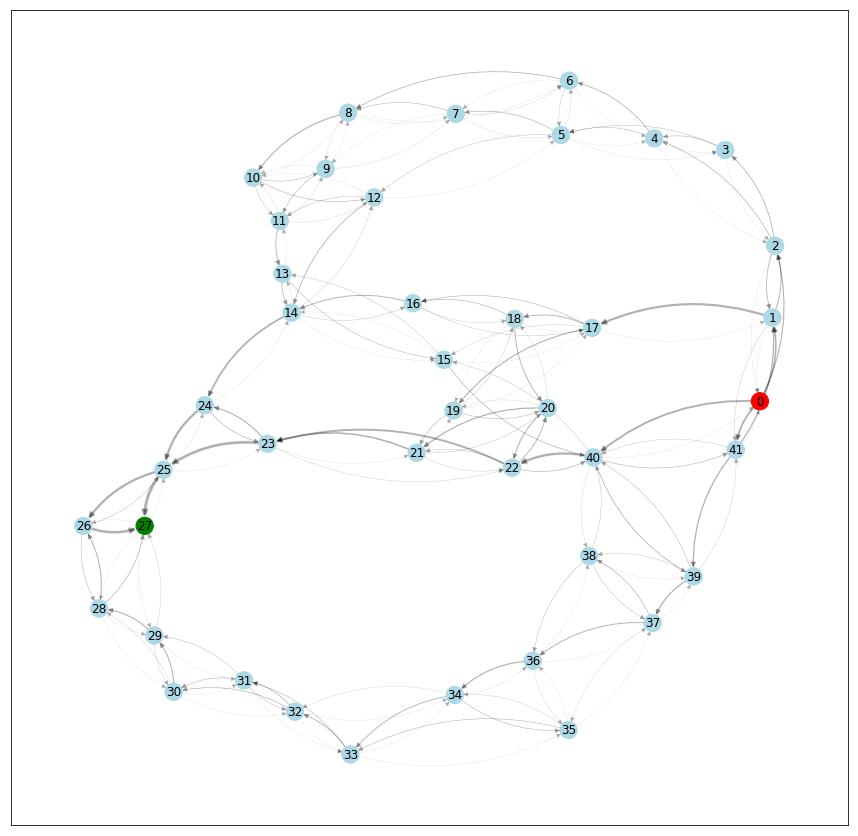

IntProgress(value=0, description='computing 1000 generations', max=1000)

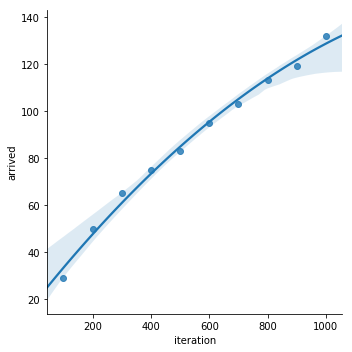

In [10]:
tAco = TimeExtendedACO(prerun_generations=100, problem=problem_middle_1, timeframe=40, normalize_eps=0.001, elitist_update=False, seed=43)
tAco.draw_pheromones(label=False)
tAco.run_extended(generations=1000, depenalize_long_running=False, alpha=0.5, beta=0.5, eps=0.001, penalty_factor=0.00, normalize_eps=0, elitist_update=False, show_progress=True)
tAco.plot_convergence()

IntProgress(value=0, description='computing 1500 generations', max=1500)

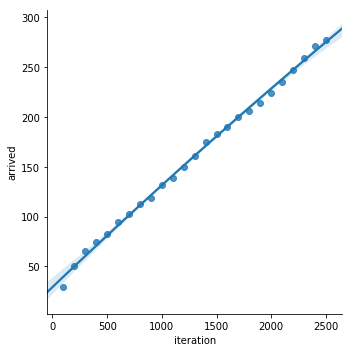

In [11]:
tAco.run_extended(generations=1500, show_progress=True)
sns.lmplot(data=tAco.df_convergence.loc[tAco.df_convergence.iteration % 100 == 0], x="iteration", y="arrived", order=2)
plt.show()

In [12]:
# tAco.widget_pheromones()

In [13]:
# tAco.widget_extended_pheromones()

In [121]:
class MultiAgentTACO:
    def __init__(self, problem=None, agents=None, timeframe=100, seed=None, **kwargs):
        self.seed = seed
        self.random = np.random.RandomState(seed=seed)
        self.agents = agents
        self.adjacency = problem.adjacency.copy()
        self.timeframe = timeframe
        self.iteration = 0
        self.kwargs = kwargs
        for agent in self.agents:
            agent["problem"] = NavigationProblem(start=agent["start"], goal=agent["goal"], pheromones=problem.pheromones, adjacency=problem.adjacency)
            agent["seed"] = self.random.randint(2**32)
            agent["tAco"] = TimeExtendedACO(timeframe=timeframe, problem=agent["problem"], seed=agent["seed"], **kwargs)
            for t in range(timeframe):
                agent["tAco"].extended_pheromones[t] = agent["tAco"].pheromones.copy()
        
    def pheromone_sum(self):
        pheromones = np.zeros_like(self.agents[0]["tAco"].extended_pheromones)
        for agent in self.agents:
            pheromones += agent["tAco"].extended_pheromones
        return pheromones
        
    
    def run(self, show_progress=False, generations=1000, **kwargs):
        self.kwargs.update(kwargs)
        if show_progress:
            progress_bar = widgets.IntProgress(min=0, max=generations, value=0)
            display(progress_bar)
        for generation in range(generations):
            self.iteration += 1
            if show_progress:
                progress_bar.value=generation
            self.step(**self.kwargs)
        
    def step(self, batch_size=10, **kwargs):
        for agent in self.agents:
            agent["tAco"].run_extended(generations=batch_size, foreign_pheromones=self.pheromone_sum() - agent["tAco"].extended_pheromones, **kwargs)
    
    def draw_extended_pheromones(self, label=True, time=-1, width=15, height=15, thickness=3, show=True, prune=0, node_label=True, agent=0):
        tAco = self.agents[agent]["tAco"]
        tAco.draw_extended_pheromones(label=label, time=time, width=width, height=height, thickness=thickness, show=show, prune=prune, node_label=node_label)
    
    def widget(self):
        w = widgets.interact(mAco.draw_extended_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 time=widgets.IntSlider(min=-1,max=mAco.timeframe-1,step=1,value=-1),
                 agent=widgets.Dropdown(options=range(len(mAco.agents))),
                 thickness=widgets.FloatLogSlider(value=3, base=10, min=-5, max=5)
                );
        display(w)
    
    def get_fitness_data(self):
        fitness = []
        for i in range(len(self.agents)):
            df = self.agents[i]["tAco"].df_fitness
            df["agent"] = i
            fitness.append(df)
        return pd.concat(fitness)
    
    def get_path_data(self):
        data = []
        for i, a in enumerate(self.agents):
            data.append(a["tAco"].get_path_data())
            data[-1]["agent"] = i
        return pd.concat(data)
    
    def compute_node_collisions(self, paths1, paths2):
        collisions = 0
        for p in paths1:
            for q in paths2:
                short, long = p, q
                if len(p) > len(q):
                    long, short = p, q
                for i, n1 in enumerate(short):
                        if n1 == long[i]:
                            collisions += 1
        return collisions / len(paths1) / len(paths2)
    
    def compute_edge_collisions(self, paths1, paths2):
        for path1 in paths1:
            for path2 in paths2:
                short, long = path1, path2
                if len(path1) > len(path2):
                    long, short = path1, path2
                for i, e1 in enumerate(zip(short[:-1], short[1:])):
                    for e2 in zip(long[:-1], long[1:]):
                        if e1 == e2:
                            collisions += 1
                        else:
                            collisions += 2
    
    def compute_latest_collisions(self):
        node_collisions = 0
        edge_collisions = 0
        for i, a in enumerate(self.agents):
            for b in self.agents[i+1:]:
                node_collisions += self.compute_node_collisions(a["tAco"].paths, b["tAco"].paths)
                edge_collisions += self.compute_edge_collisions(a["tAco"].paths, b["tAco"].paths)
        return node_collisions, edge_collisions
            
    
    def validate_latest_paths(self):
        df = self.get_path_data().groupby("agent").mean().mean()
        n, e = self.compute_latest_collisions()
        df["node_collisions"] = n
        df["edge_collisions"] = e
        df["collisions"] = n + e
        df["iteration"] = self.iteration
        return df

In [15]:
problem = problem_easy_4
mAco = MultiAgentTACO(problem=problem, agents=[
    {"start":problem.start, "goal":problem.goal},
    {"start":problem.goal, "goal":problem.start}]
                      , timeframe=10, prerun_generations=40, seed=42,c_amount=1, c_f=300, c_t=0.1, c_d=1)
#mAco.step(alpha_foreign=0.5)

In [16]:
mAco.run(show_progress=True, generations=300)

IntProgress(value=0, max=300)

In [17]:
mAco.widget()

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=-1, description='time', max=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Best Distance Found: inf
[]


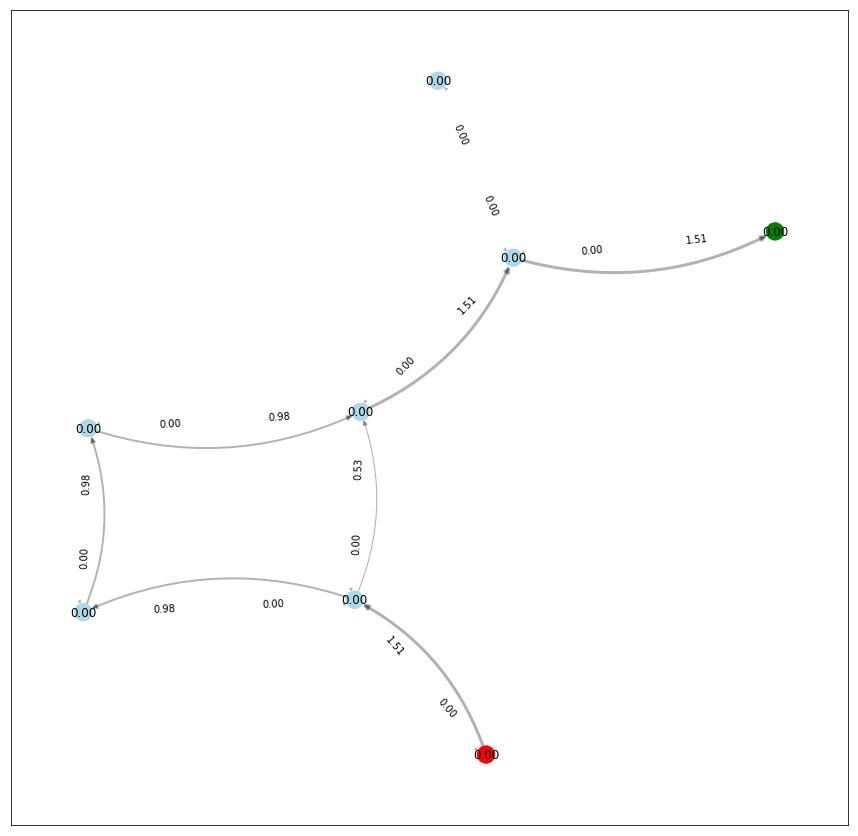

In [18]:
mAco.agents[1]["tAco"].draw_pheromones()

In [160]:
class Parameter:
    def __init__(self, name, values=None, default=1.0):
        self.name = name
        self.values = values
        self.default = default

class ExperimentRunner:
    def __init__(self, problem=None, agents=None, parameters=[], step_size=50, step_count=3, independend_runs=31, seed=0):
        self.parameters = parameters
        self.seed = seed
        self.step_size = step_size
        self.step_count = step_count
        self.independend_runs = independend_runs
        self.data = []
        self.problem = problem
        self.agents = agents
    
    def get_default_kwargs(self):
        return {parameter.name : parameter.default for parameter in self.parameters}
    
    def log_run_data(self, mAco, **kwargs):
        df = mAco.validate_latest_paths()
        for param in self.parameters:
            if param.values is not None and param.name in kwargs.keys():
                df[param.name] = kwargs[param.name]
        df["run"] = self.run_number
        self.run_data.append(df)
        
    def run_defaults(self):
        self.run()
        
    def run(self, overwrite={}):
        self.run_data = []
        kwargs = self.get_default_kwargs()
        kwargs.update(overwrite)
        for run in range(self.independend_runs):
            self.run_number=run
            seed = self.seed + run
            mAco = MultiAgentTACO(problem=self.problem, agents=self.agents, seed=seed, **kwargs)
            self.log_run_data(mAco, **kwargs)
            for step in range(self.step_count):
                mAco.run(generations=self.step_size)
                self.log_run_data(mAco, **kwargs)
        self.data.append(pd.DataFrame(self.run_data))
    
    def run_non_defaults(self):
        progress = widgets.IntProgress(min=0, max=len(parameters), value=0, description="")
        display(progress)
        for parameter in self.parameters:
            progress.value += 1
            progress.description= parameter.name
            if parameter.values is None:
                continue
            for value in parameter.values:
                if value == parameter.default:
                    continue
                self.run(overwrite={parameter.name: value})
    
    def run_all(self):
        print("running defaults")
        self.run_defaults()
        print("running non defaults")
        self.run_non_defaults()
    
    def get_data(self):
        return pd.concat(self.data, ignore_index=True)
    
    def store(self, filename="benchmark.pkl"):
        pd.to_pickle(self.get_data(), filename)
        
        

In [137]:
problem = problem_easy_4
agents=[
    {"start":problem.start, "goal":problem.goal},
    {"start":problem.goal, "goal":problem.start}]
ls = np.logspace(-1, 1, num=5)
parameters = [
    Parameter("prerun_generations", default=50),
    Parameter("alpha", values=ls, default=1.0),
    Parameter("beta", default=1.0, values=ls),
    Parameter("eps_foreign", default=1.0, values=ls),
    Parameter("show_progress", default=False),
    Parameter("timeframe", default=20),
    Parameter("eps", values=ls),
    Parameter("alpha_foreign", values=ls),
    Parameter("c_amount", values=ls*50),
    Parameter("c_f", values=ls*50),
    Parameter("c_t", values=ls*10),
    Parameter("c_d", values=ls*10),
]
runner = ExperimentRunner(problem=problem, agents=agents, independend_runs=7, parameters=parameters, step_size=20)

In [138]:
runner.run_all()

running defaults
running non defaults


IntProgress(value=0, max=12)

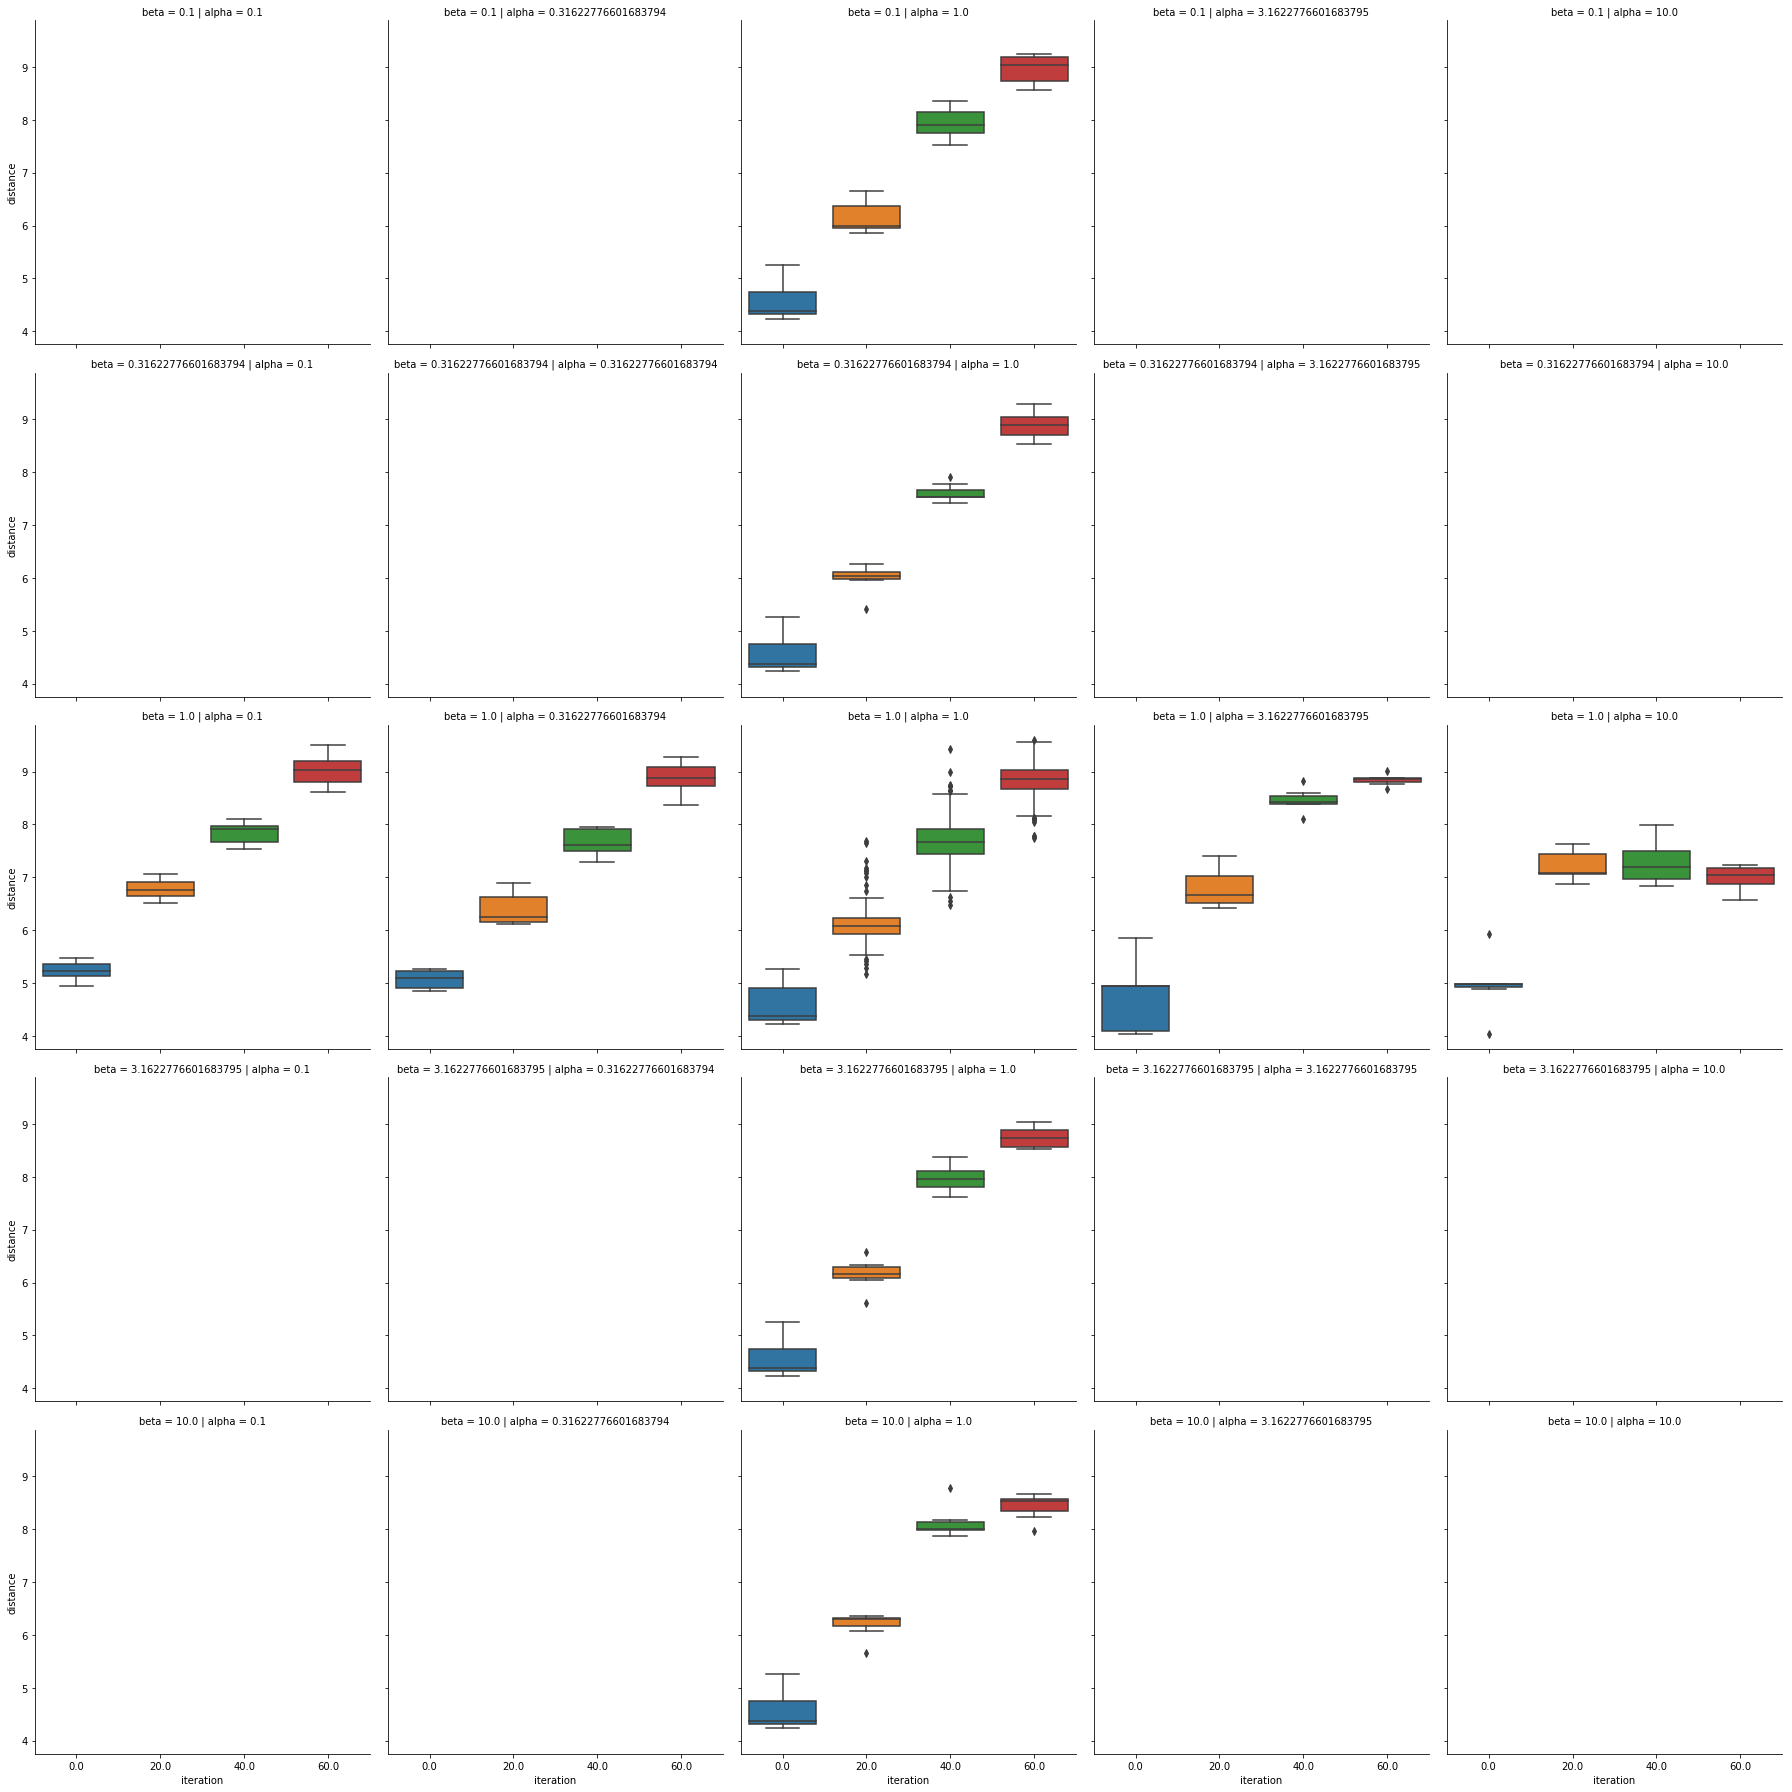

In [140]:
df = runner.get_data()
sns.catplot(data=df.loc[df.eps_foreign == 1.0], x="iteration", y="distance", col="alpha", row="beta", kind="box")

In [152]:
def explore_parameter(data=None, parameters=None, name="Name"):
    df = data
    for parameter in parameters:
        if parameter.name != name and parameter.name in df.keys():
            df = df.loc[df[parameter.name] == parameter.default]
    return df

def plot_parameter(data=None, parameters=None, name="Name"):
    df_eps_f = explore_parameter(data=data, parameters=parameters, name=name)
    sns.catplot(data=df_eps_f, x="iteration", y="node_collisions", col=name, kind="box")
    

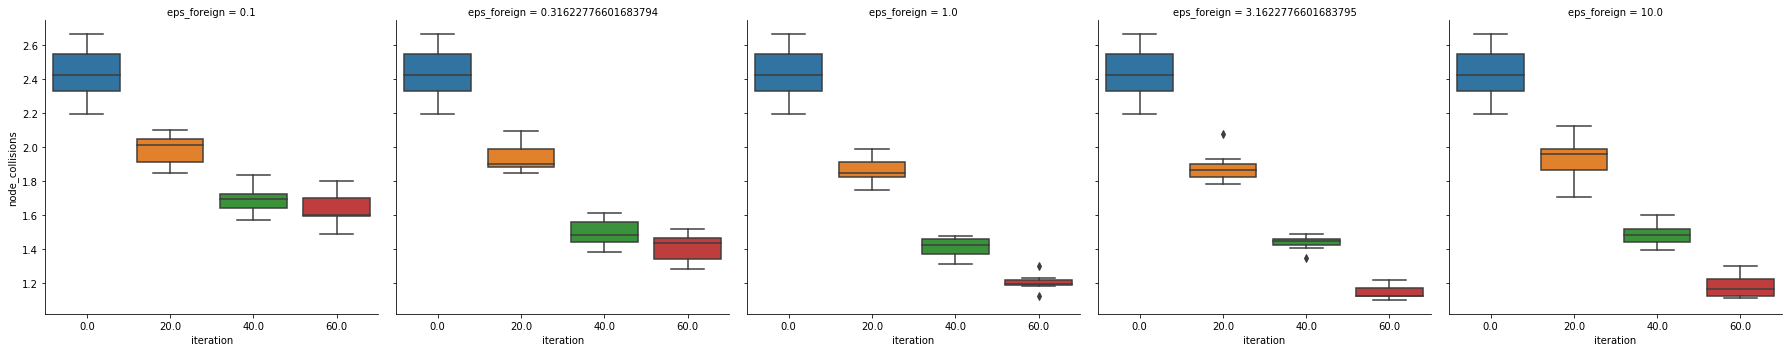

In [151]:
df_eps_f = explore_parameter(data=df, parameters=parameters, name="eps_foreign")
sns.catplot(data=df_eps_f, x="iteration", y="node_collisions", col="eps_foreign", kind="box")

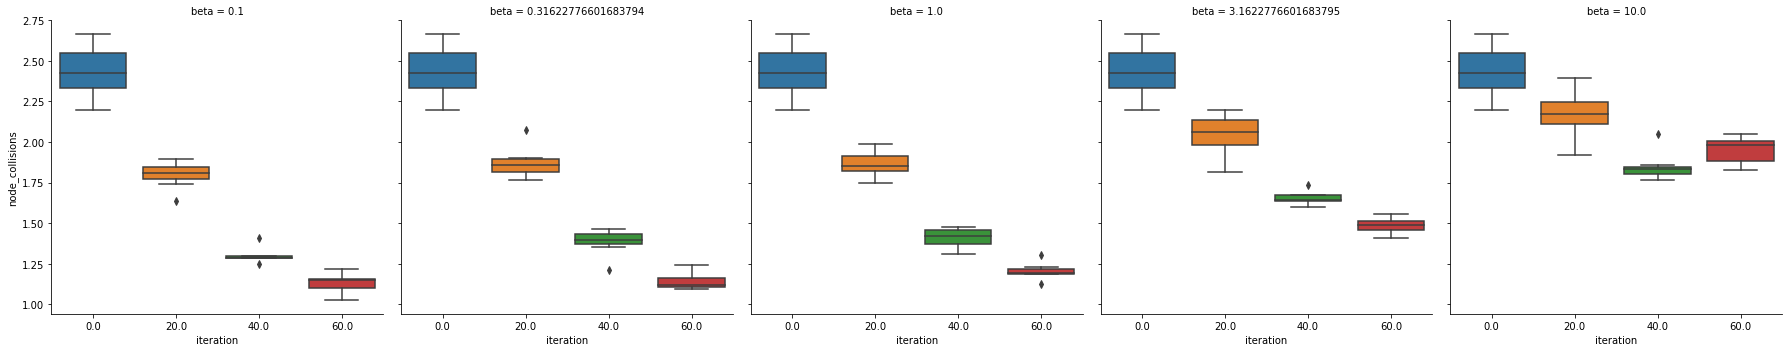

In [155]:
plot_parameter(data=df, parameters=parameters, name="beta")

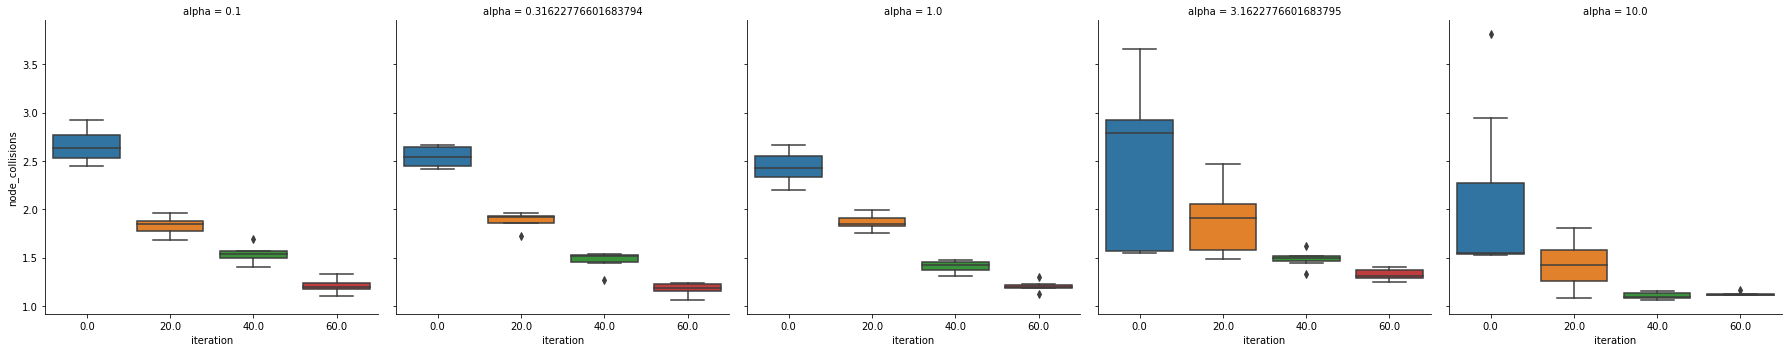

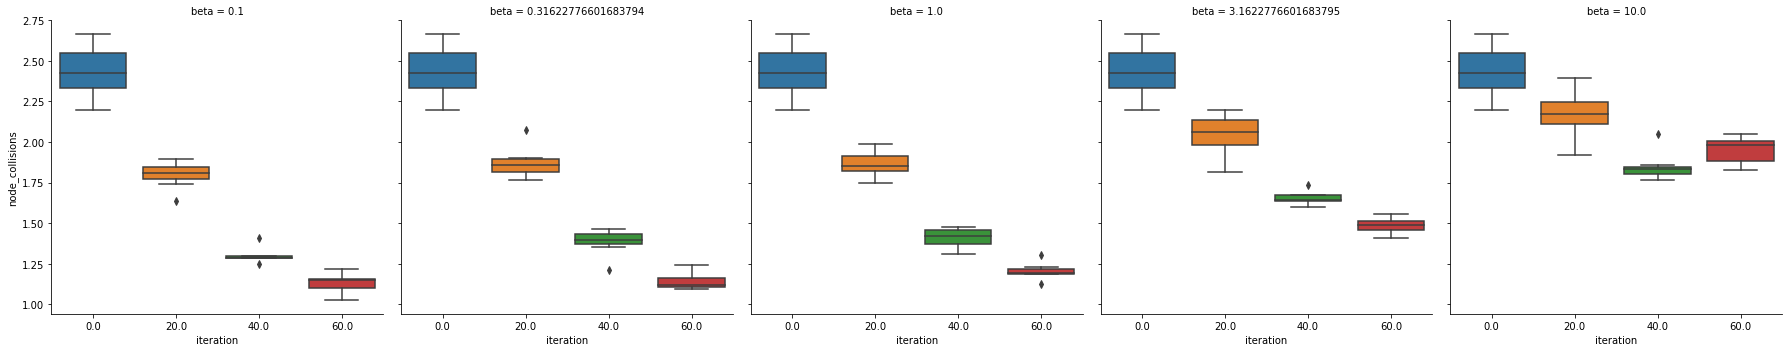

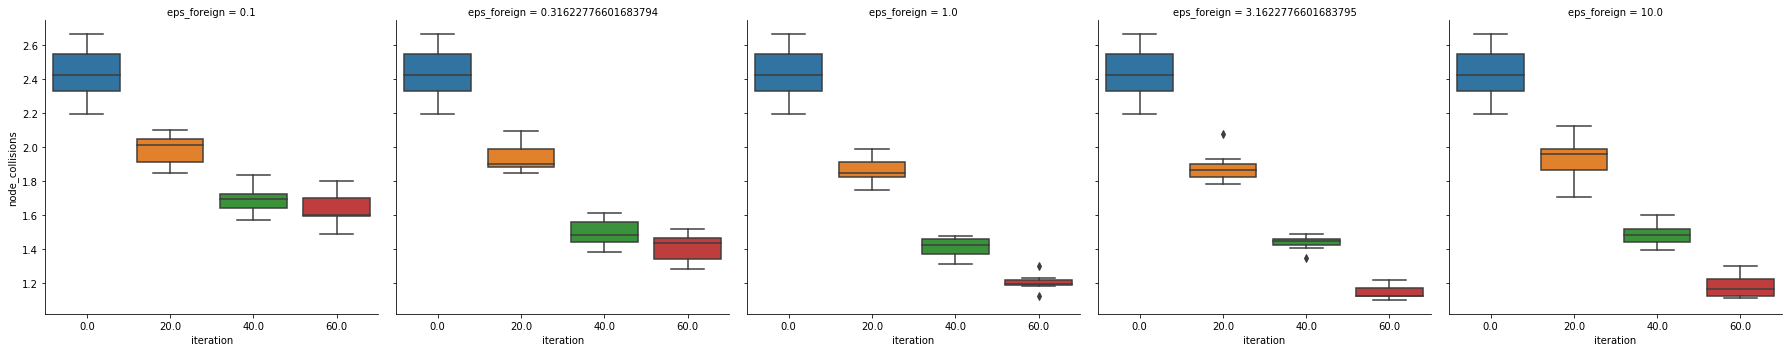

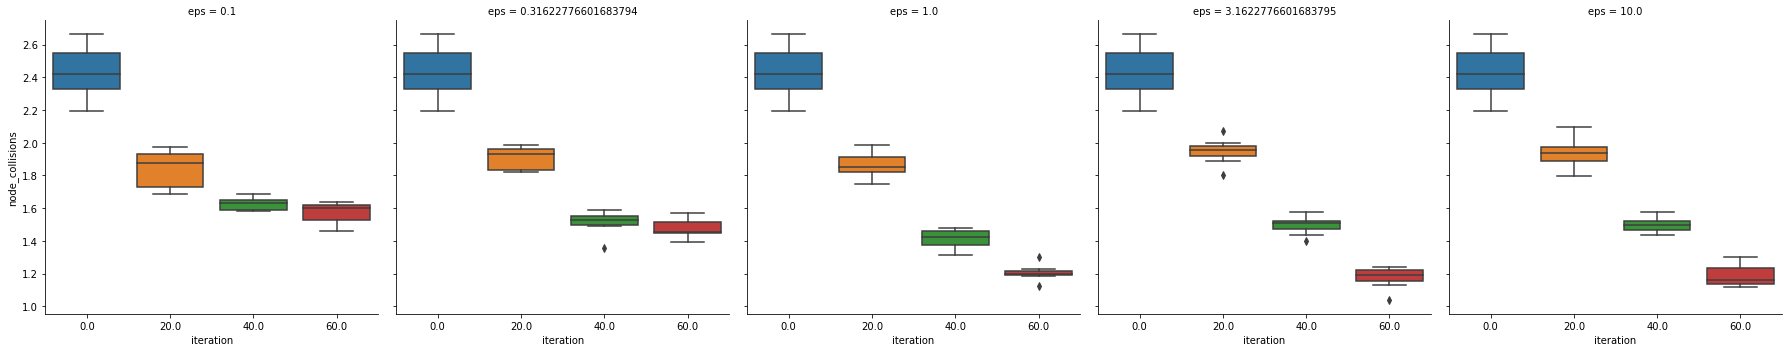

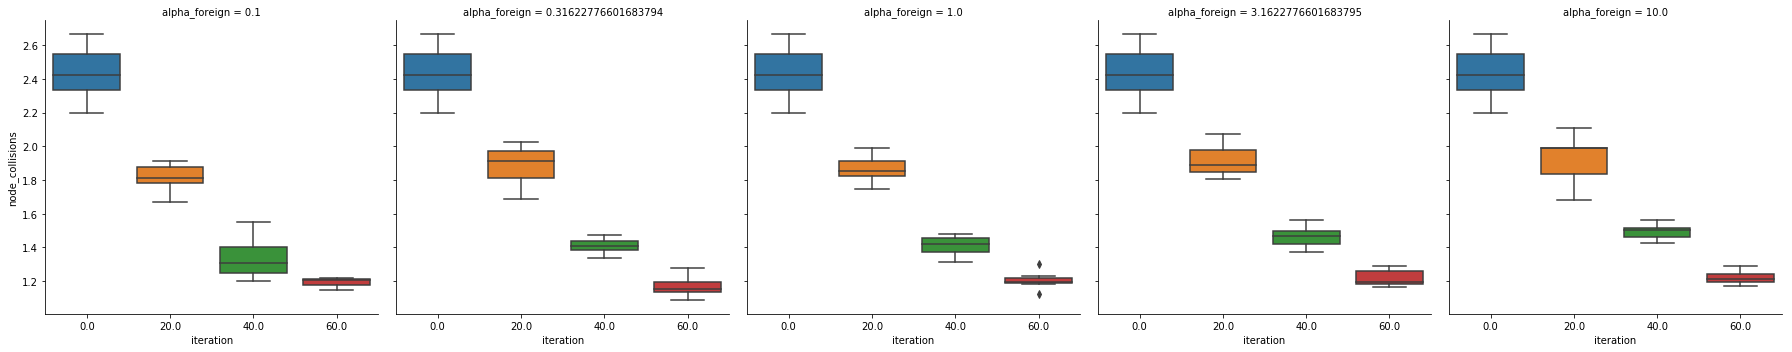

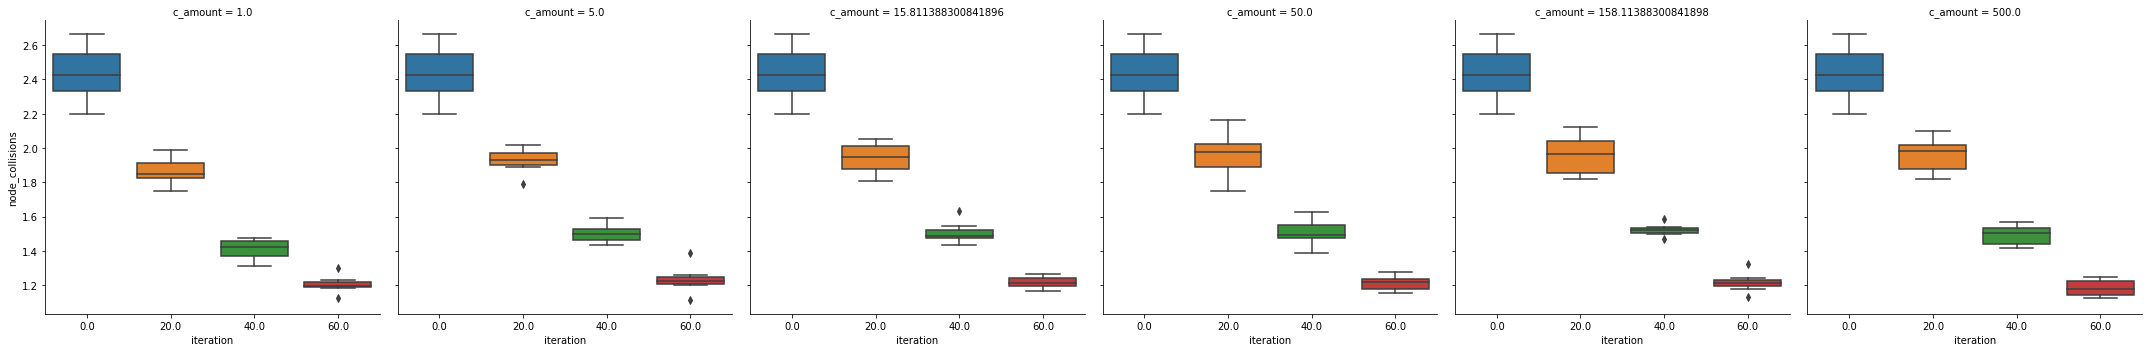

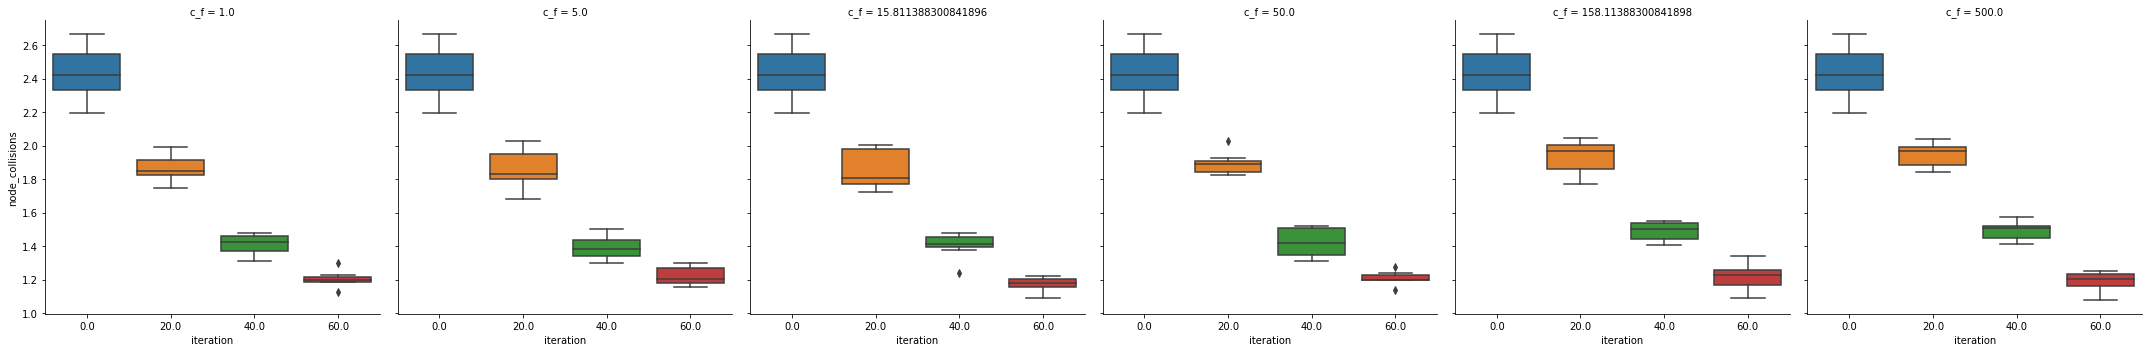

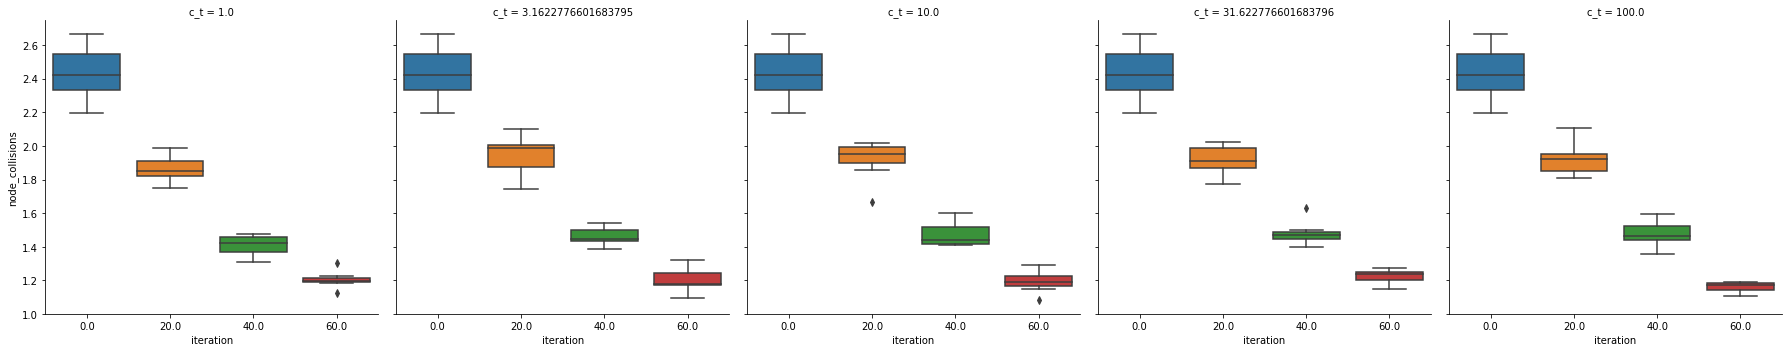

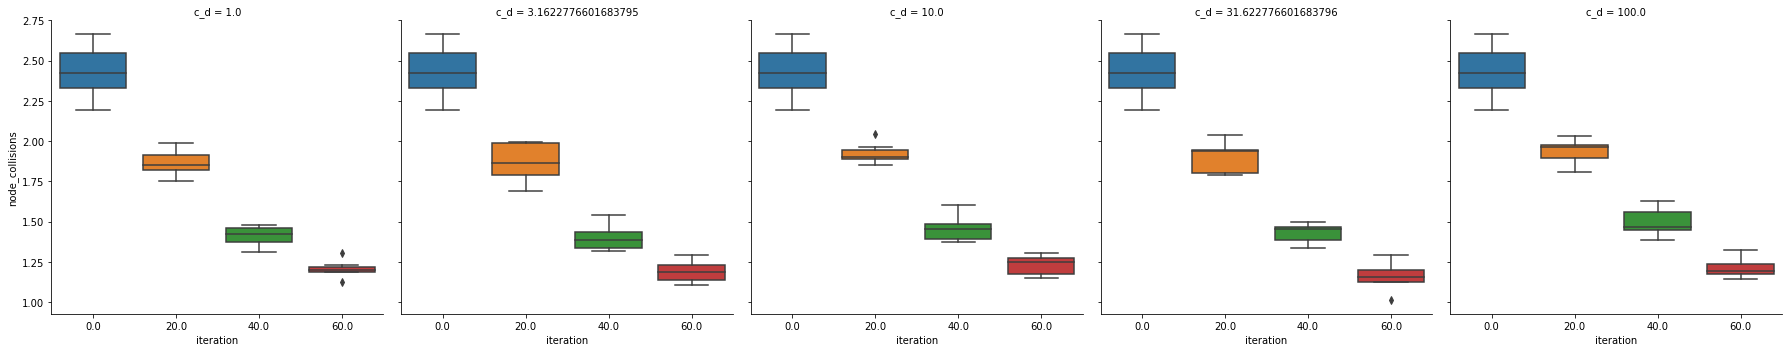

In [157]:
for p in parameters:
    if p.values is not None:
        plot_parameter(data=df, parameters=parameters, name=p.name)
        plt.show()

,distance,length,node_collisions,edge_collisions,collisions,iteration,alpha,beta,eps_foreign,eps,alpha_foreign,c_amount,c_f,c_t,c_d
0,4.234783,5.234783,2.667065,0.0,2.667065,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
1,6.180000,8.175000,1.989100,0.0,1.989100,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
2,8.530000,11.695000,1.311900,0.0,1.311900,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
3,9.250000,12.825000,1.204800,0.0,1.204800,60.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
4,4.377895,5.377895,2.423368,0.0,2.423368,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
5,6.030000,8.050000,1.850600,0.0,1.850600,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
6,7.770000,10.650000,1.349500,0.0,1.349500,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
7,8.840000,12.345000,1.196500,0.0,1.196500,60.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
8,5.258120,6.258120,2.318376,0.0,2.318376,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
9,6.440000,8.465000,1.846600,0.0,1.846600,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
